### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [20]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-05-07 14:13:18--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat.1’

ising2_label.dat.1  100%[===================>]  79.13K   314KB/s    in 0.3s    

2020-05-07 14:13:19 (314 KB/s) - ‘ising2_label.dat.1’ saved [81025/81025]

--2020-05-07 14:13:20--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat.1’

ising2_conf.dat.1   100%[===================>]  18.18M  6.19MB/s    in 2.9s    

2020-05-07 14:13:23 (6.19 MB/s) - ‘ising2_conf.dat.1’ saved [1906077

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [21]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-rc4


In [22]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [23]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


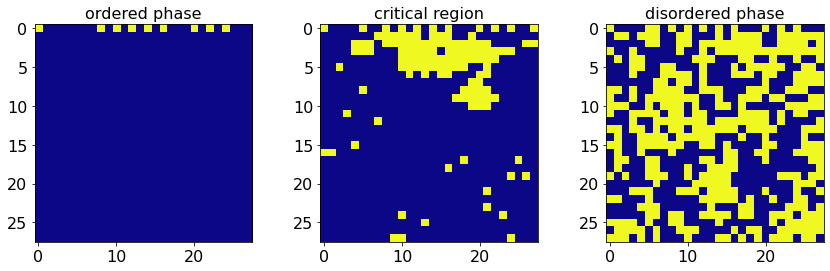

In [0]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [24]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [44]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
data = (X_train,X_test,Y_train,Y_test)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

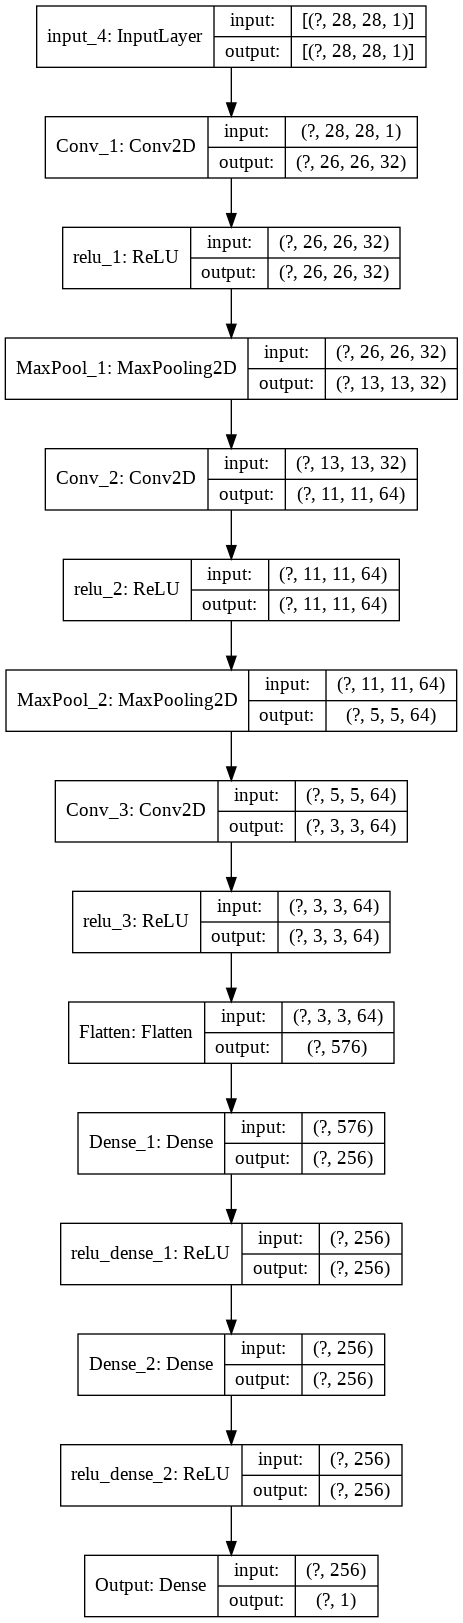

In [42]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
def output_from_input(inputs, data_augment=False, activation="relu"):
  if activation=="relu":
    layer_with_activation = keras.layers.ReLU
  elif activation=="l_relu":
    layer_with_activation = keras.layers.LeakyReLU
  elif activation=="elu":
    layer_with_activation = keras.layers.ELU

  if data_augment:
    x = data_augmentation(inputs)
  else:
    x = inputs

  # CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
  # da una rete densa come classificatore

  #
  # singolo blocco convoluzionale: conv2D + maxPooling 
  # attvazione: ReLu

  # primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
  #tf.keras.layers.Conv2D(
  #    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
  #    dilation_rate=(1, 1), activation=None, use_bias=True,
  #    kernel_initializer='glorot_uniform', bias_initializer='zeros',
  #    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
  #    kernel_constraint=None, bias_constraint=None, **kwargs
  #)
  #tf.keras.layers.ReLU(
  #    max_value=None, negative_slope=0, threshold=0, **kwargs
  #)
  #tf.keras.layers.MaxPool2D(
  #    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
  #)
  # NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
  # ridurre la size dell'immagine dopo lapplicazione del filtro

  #
  # primo blocco Convoluzionale
  x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
  x = layer_with_activation(name=f'{activation}_1')(x)
  x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

  # secondo blocco convoluzionale
  x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
  x = layer_with_activation(name=f'{activation}_2')(x)
  x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

  # terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
  # troppo la dimensione dell'output x)
  x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
  x = layer_with_activation(name=f'{activation}_3')(x)

  # appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
  # vettore piatto come input per la rete densa

  x = keras.layers.Flatten(name='Flatten')(x)

  # rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
  # layer di uscita costituito da 1 neurone con funzione di attivazione lineare
  # che produce in output la stima della temperatura associata alla configurazione
  # in input

  # Layer denso in Keras
  #tf.keras.layers.Dense(
  #    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
  #    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
  #    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
  #    **kwargs
  #)
  x = keras.layers.Dense(256, name='Dense_1')(x)
  x = layer_with_activation(name=f'{activation}_dense_1')(x)
  x = keras.layers.Dense(256, name='Dense_2')(x)
  x = layer_with_activation(name=f'{activation}_dense_2')(x)
  outputs = keras.layers.Dense(1, name='Output')(x)
  return outputs

outputs = output_from_input(inputs)
#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ 
  model_checkpoint, 
  #lr_scheduler,
]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 6s 111ms/step - loss: 0.7300 - mean_absolute_error: 0.5953 - val_loss: 0.2409 - val_mean_absolute_error: 0.4171
Epoch 2/30
50/50 [==============================] - 5s 107ms/step - loss: 0.2124 - mean_absolute_error: 0.3889 - val_loss: 0.1905 - val_mean_absolute_error: 0.3578
Epoch 3/30
50/50 [==============================] - 5s 107ms/step - loss: 0.1627 - mean_absolute_error: 0.3318 - val_loss: 0.1433 - val_mean_absolute_error: 0.2982
Epoch 4/30
50/50 [==============================] - 5s 106ms/step - loss: 0.1308 - mean_absolute_error: 0.2931 - val_loss: 0.1323 - val_mean_absolute_error: 0.2937
Epoch 5/30
50/50 [==============================] - 5s 107ms/step - loss: 0.1246 - mean_absolute_error: 0.2824 - val_loss: 0.1174 - val_mean_absolute_error: 0.2653
Epoch 6/30
50/50 [==============================] - 5s 108ms/step - loss: 0.1148 - mean_absolute_error: 0.2695 - val_loss: 0.1052 - val_mean_absolute_error: 0.2571
Epoch 7/30
50/50

In [0]:
model.load_weights("mycnn_29")
model.save("/content/drive/My Drive/Colab Notebooks/mycnn_29.hdf5")

In [0]:
# model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/mycnn_29.hdf5")

In [27]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 1s - loss: 0.0717 - mean_absolute_error: 0.1957

Test loss (MSE): 0.0717029795050621

Test MAE: 0.19565778970718384


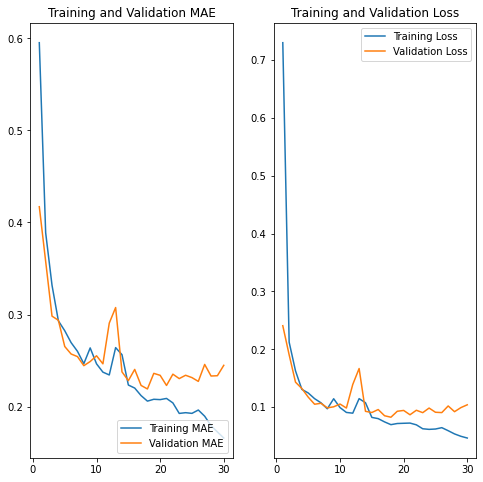

In [0]:
#plot della loss e della MAE durante il training
def plot_history(history):
  train_mae = history.history['mean_absolute_error']
  val_mae = history.history['val_mean_absolute_error']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(1, len(loss) + 1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, mae, label='Training MAE')
  plt.plot(epochs_range, val_mae, label='Validation MAE')
  plt.legend(loc='lower right')
  plt.title('Training and Validation MAE')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
plot_history(history)

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.344690 VS 0.608977 Diff= -0.264287
Predicted vs True T: 4.408219 VS 4.613420 Diff= -0.205201
Predicted vs True T: 1.278973 VS 1.332020 Diff= -0.053047
Predicted vs True T: 4.380025 VS 4.295360 Diff= 0.084665
Predicted vs True T: 4.258642 VS 4.922180 Diff= -0.663538
Predicted vs True T: 2.737210 VS 2.603500 Diff= 0.133710
Predicted vs True T: 1.690681 VS 1.617580 Diff= 0.073101
Predicted vs True T: 1.446881 VS 1.540610 Diff= -0.093729
Predicted vs True T: 2.505461 VS 2.493560 Diff= 0.011901
Predicted vs True T: 4.242313 VS 4.620070 Diff= -0.377757
Sample MAE:  [0.19609372]


In [28]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc
def classify(model, X_test, Y_test, T_c):
  T_c=2.26 # Temperatura critica

  # predizioni della CNN sull'intero campione di Test
  predictions = model.predict(X_test)


  # conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
  N_ord_corrette = 0 
  N_dis_corrette = 0
  N_all = 0
  for i in range(predictions.shape[0]):
    if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
      N_ord_corrette = N_ord_corrette + 1
    if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
      N_dis_corrette = N_dis_corrette + 1

  N_all = Y_test.shape[0]   

  accuracy = (N_ord_corrette+N_dis_corrette)/N_all
  print('Accuracy is: ', accuracy)

classify(model, X_test, Y_test, 2.26)

Accuracy is:  0.9855


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

# Attivare learning rate decay

In [0]:
def create_model_and_train(
    X_train, X_test, Y_train, Y_test, 
    callbacks, **kwargs
):
  outputs = output_from_input(inputs, **kwargs)
  #definizione del modello
  model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

  #printout il summary del modello
  model.summary()

  # struttura el modello
  keras.utils.plot_model(model, show_shapes=True)

  model.compile(optimizer=OPTIMIZER,
                loss=mse,
                metrics=[mae],
                run_eagerly=EAGERLY)

  history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                      validation_split=0.2, shuffle=True, verbose=1,
                      callbacks=callbacks)

  test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
  print('\nTest loss (MSE):', test_loss)
  print('\nTest MAE:', test_mae)
  plot_history(history)
  classify(model, X_test, Y_test, 2.26)
  return (history, model)

In [0]:
LR_ST = 1e-3
# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    eta = LR_ST
  else:
    eta = LR_ST * tf.math.exp(0.2 * (10 - epoch))
  print(f"learning rate: {float(eta)}")
  return eta

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

callbacks = [ 
    model_checkpoint, 
    lr_scheduler,
  ]

create_model_and_train(*data, callbacks)

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

# Attivare Data Augmentation

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0 

# Altre funzioni di attivazione

In [43]:
outputs = output_from_input(inputs, activation="l_relu")
#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
l_relu_1 (LeakyReLU)         (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
l_relu_2 (LeakyReLU)         (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

**Trovare gi iprparametri ottimali del modello con** *Keras Tuner*

Dato un modello funzionante il passo successivo è quello di ottimizzarne l'archiettura. Questo può essere fatto manualmente (alcuni esempi li abbiamo visti sopra intorducendo il decay del learning rate o introducendo procedure di data_augmentation), oppure in modo sistematico usando tool appositi. Uno di tali tool, semplice e che funziona con keras è appunto [*Keras Tuner*](https://keras-team.github.io/keras-tuner/)


Uso:

1.   si modifica la definizione del modello in modo che acectti un parametro *hp* e in modo tale da modificare gli iperparametri del modello in accordo a diversi metodi di sampling *(hp.Int(), hp.Choice(), ...)*  
2.   si istanzia un oggetto di tipo *tuner* che definisce la strategia di tuning da seguire
3.   si fa partire la ricerca dei parametri e si prina il risultato finale

Esempio pratico:

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxP Itool2D((2,2))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.ReLU()(x)
  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  return model

In [0]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=125bbb226232db2c4a4a2672d1c6ddf8c812f546bd4ac68bc866670b01e92671
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=c2d1fc5a18b180c62f167ee89d0dc186fc1de95c96ef0b97320f184ccd355b0b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='ottim_dir')

INFO:tensorflow:Reloading Oracle from existing project ottim_dir/untitled_project/oracle.json


In [0]:
# start optimisation search
X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

Epoch 1/10
125/125 [==============================] - 13s 101ms/step - loss: 3.0988 - mae: 0.7517 - val_loss: 0.2169 - val_mae: 0.4025
Epoch 2/10
125/125 [==============================] - 15s 124ms/step - loss: 0.2018 - mae: 0.3892 - val_loss: 0.1989 - val_mae: 0.3868
Epoch 3/10
125/125 [==============================] - 13s 105ms/step - loss: 0.1884 - mae: 0.3747 - val_loss: 0.1901 - val_mae: 0.3770
Epoch 4/10
125/125 [==============================] - 13s 102ms/step - loss: 0.1754 - mae: 0.3596 - val_loss: 0.1845 - val_mae: 0.3604
Epoch 5/10
125/125 [==============================] - 13s 102ms/step - loss: 0.1629 - mae: 0.3426 - val_loss: 0.1697 - val_mae: 0.3496
Epoch 6/10
125/125 [==============================] - 13s 101ms/step - loss: 0.1483 - mae: 0.3238 - val_loss: 0.1571 - val_mae: 0.3325
Epoch 7/10
125/125 [==============================] - 13s 103ms/step - loss: 0.1320 - mae: 0.3023 - val_loss: 0.1459 - val_mae: 0.3165
Epoch 8/10
125/125 [==============================] - 1

Epoch 1/10
125/125 [==============================] - 9s 76ms/step - loss: 262.3578 - mae: 2.2350 - val_loss: 0.1877 - val_mae: 0.3644
Epoch 2/10
125/125 [==============================] - 9s 74ms/step - loss: 0.1906 - mae: 0.3603 - val_loss: 0.2704 - val_mae: 0.4165
Epoch 3/10
125/125 [==============================] - 9s 74ms/step - loss: 0.1984 - mae: 0.3596 - val_loss: 0.1653 - val_mae: 0.3201
Epoch 4/10
125/125 [==============================] - 9s 74ms/step - loss: 0.1493 - mae: 0.3085 - val_loss: 0.1344 - val_mae: 0.3003
Epoch 5/10
125/125 [==============================] - 9s 75ms/step - loss: 0.1281 - mae: 0.2854 - val_loss: 0.1311 - val_mae: 0.3019
Epoch 6/10
125/125 [==============================] - 9s 74ms/step - loss: 0.1300 - mae: 0.2861 - val_loss: 0.1798 - val_mae: 0.3410
Epoch 7/10
125/125 [==============================] - 9s 73ms/step - loss: 0.1106 - mae: 0.2662 - val_loss: 0.1843 - val_mae: 0.3442
Epoch 8/10
125/125 [==============================] - 9s 73ms/step 

Epoch 1/10
125/125 [==============================] - 9s 68ms/step - loss: 239.2194 - mae: 1.9825 - val_loss: 0.1554 - val_mae: 0.3319
Epoch 2/10
125/125 [==============================] - 9s 69ms/step - loss: 0.1485 - mae: 0.3105 - val_loss: 0.1539 - val_mae: 0.3135
Epoch 3/10
125/125 [==============================] - 9s 68ms/step - loss: 0.1113 - mae: 0.2697 - val_loss: 0.1304 - val_mae: 0.2873
Epoch 4/10
125/125 [==============================] - 9s 68ms/step - loss: 0.1067 - mae: 0.2586 - val_loss: 0.1722 - val_mae: 0.3359
Epoch 5/10
125/125 [==============================] - 8s 68ms/step - loss: 0.0959 - mae: 0.2441 - val_loss: 0.1307 - val_mae: 0.2823
Epoch 6/10
125/125 [==============================] - 9s 69ms/step - loss: 0.0748 - mae: 0.2145 - val_loss: 0.1280 - val_mae: 0.2894
Epoch 7/10
125/125 [==============================] - 9s 69ms/step - loss: 0.0703 - mae: 0.2066 - val_loss: 0.1176 - val_mae: 0.2749
Epoch 8/10
125/125 [==============================] - 8s 67ms/step 

Epoch 1/10
125/125 [==============================] - 8s 65ms/step - loss: 0.3394 - mae: 0.4476 - val_loss: 0.1933 - val_mae: 0.3593
Epoch 2/10
125/125 [==============================] - 10s 81ms/step - loss: 0.1557 - mae: 0.3283 - val_loss: 0.1502 - val_mae: 0.3154
Epoch 3/10
125/125 [==============================] - 9s 72ms/step - loss: 0.1247 - mae: 0.2888 - val_loss: 0.1317 - val_mae: 0.2945
Epoch 4/10
125/125 [==============================] - 8s 65ms/step - loss: 0.1052 - mae: 0.2634 - val_loss: 0.1252 - val_mae: 0.2824
Epoch 5/10
125/125 [==============================] - 8s 64ms/step - loss: 0.0998 - mae: 0.2549 - val_loss: 0.1388 - val_mae: 0.3058
Epoch 6/10
125/125 [==============================] - 8s 64ms/step - loss: 0.0914 - mae: 0.2413 - val_loss: 0.1732 - val_mae: 0.3421
Epoch 7/10
125/125 [==============================] - 8s 64ms/step - loss: 0.0827 - mae: 0.2310 - val_loss: 0.1476 - val_mae: 0.3094
Epoch 8/10
125/125 [==============================] - 8s 65ms/step -

Epoch 1/10
125/125 [==============================] - 10s 80ms/step - loss: 1.6635 - mae: 0.6196 - val_loss: 0.1968 - val_mae: 0.3836
Epoch 2/10
125/125 [==============================] - 10s 80ms/step - loss: 0.1879 - mae: 0.3688 - val_loss: 0.1903 - val_mae: 0.3721
Epoch 3/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1630 - mae: 0.3409 - val_loss: 0.1884 - val_mae: 0.3647
Epoch 4/10
125/125 [==============================] - 10s 80ms/step - loss: 0.1471 - mae: 0.3224 - val_loss: 0.1839 - val_mae: 0.3568
Epoch 5/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1305 - mae: 0.2999 - val_loss: 0.1554 - val_mae: 0.3196
Epoch 6/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1228 - mae: 0.2865 - val_loss: 0.1487 - val_mae: 0.3162
Epoch 7/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1061 - mae: 0.2654 - val_loss: 0.1503 - val_mae: 0.3109
Epoch 8/10
125/125 [==============================] - 10s 79ms

Epoch 1/10
125/125 [==============================] - 7s 53ms/step - loss: 0.3817 - mae: 0.4683 - val_loss: 0.1866 - val_mae: 0.3680
Epoch 2/10
125/125 [==============================] - 7s 52ms/step - loss: 0.1699 - mae: 0.3447 - val_loss: 0.2238 - val_mae: 0.3928
Epoch 3/10
125/125 [==============================] - 7s 53ms/step - loss: 0.1394 - mae: 0.3087 - val_loss: 0.1429 - val_mae: 0.3071
Epoch 4/10
125/125 [==============================] - 7s 52ms/step - loss: 0.1116 - mae: 0.2713 - val_loss: 0.1511 - val_mae: 0.3016
Epoch 5/10
125/125 [==============================] - 7s 52ms/step - loss: 0.1004 - mae: 0.2548 - val_loss: 0.1285 - val_mae: 0.2913
Epoch 6/10
125/125 [==============================] - 7s 53ms/step - loss: 0.0866 - mae: 0.2375 - val_loss: 0.1174 - val_mae: 0.2729
Epoch 7/10
125/125 [==============================] - 7s 53ms/step - loss: 0.0843 - mae: 0.2334 - val_loss: 0.1158 - val_mae: 0.2662
Epoch 8/10
125/125 [==============================] - 7s 53ms/step - 

Epoch 1/10
125/125 [==============================] - 10s 79ms/step - loss: 0.3779 - mae: 0.4661 - val_loss: 0.2033 - val_mae: 0.3803
Epoch 2/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1679 - mae: 0.3441 - val_loss: 0.1558 - val_mae: 0.3274
Epoch 3/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1367 - mae: 0.3059 - val_loss: 0.1416 - val_mae: 0.3146
Epoch 4/10
125/125 [==============================] - 10s 78ms/step - loss: 0.1111 - mae: 0.2713 - val_loss: 0.1461 - val_mae: 0.3165
Epoch 5/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1080 - mae: 0.2670 - val_loss: 0.1203 - val_mae: 0.2851
Epoch 6/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0937 - mae: 0.2470 - val_loss: 0.1578 - val_mae: 0.3090
Epoch 7/10
125/125 [==============================] - 10s 78ms/step - loss: 0.0913 - mae: 0.2414 - val_loss: 0.1146 - val_mae: 0.2751
Epoch 8/10
125/125 [==============================] - 10s 79ms

Epoch 1/10
125/125 [==============================] - 12s 96ms/step - loss: 0.3513 - mae: 0.4568 - val_loss: 0.1980 - val_mae: 0.3731
Epoch 2/10
125/125 [==============================] - 12s 98ms/step - loss: 0.1716 - mae: 0.3475 - val_loss: 0.1639 - val_mae: 0.3410
Epoch 3/10
125/125 [==============================] - 12s 96ms/step - loss: 0.1450 - mae: 0.3147 - val_loss: 0.1564 - val_mae: 0.3284
Epoch 4/10
125/125 [==============================] - 12s 97ms/step - loss: 0.1210 - mae: 0.2831 - val_loss: 0.1334 - val_mae: 0.2997
Epoch 5/10
125/125 [==============================] - 12s 97ms/step - loss: 0.1004 - mae: 0.2578 - val_loss: 0.1286 - val_mae: 0.2950
Epoch 6/10
125/125 [==============================] - 12s 97ms/step - loss: 0.0893 - mae: 0.2421 - val_loss: 0.1251 - val_mae: 0.2880
Epoch 7/10
125/125 [==============================] - 12s 98ms/step - loss: 0.0838 - mae: 0.2329 - val_loss: 0.1224 - val_mae: 0.2871
Epoch 8/10
125/125 [==============================] - 12s 96ms

Epoch 1/10
125/125 [==============================] - 4s 28ms/step - loss: 12.9444 - mae: 0.9290 - val_loss: 0.1874 - val_mae: 0.3606
Epoch 2/10
125/125 [==============================] - 3s 28ms/step - loss: 0.1755 - mae: 0.3532 - val_loss: 0.1663 - val_mae: 0.3378
Epoch 3/10
125/125 [==============================] - 4s 28ms/step - loss: 0.1677 - mae: 0.3376 - val_loss: 0.1727 - val_mae: 0.3454
Epoch 4/10
125/125 [==============================] - 3s 28ms/step - loss: 0.1657 - mae: 0.3345 - val_loss: 0.1506 - val_mae: 0.3236
Epoch 5/10
125/125 [==============================] - 3s 28ms/step - loss: 0.1345 - mae: 0.3021 - val_loss: 0.2112 - val_mae: 0.3755
Epoch 6/10
125/125 [==============================] - 4s 29ms/step - loss: 0.1273 - mae: 0.2896 - val_loss: 0.1621 - val_mae: 0.3262
Epoch 7/10
125/125 [==============================] - 4s 28ms/step - loss: 0.1118 - mae: 0.2723 - val_loss: 0.1458 - val_mae: 0.3121
Epoch 8/10
125/125 [==============================] - 3s 28ms/step -

Epoch 1/10
125/125 [==============================] - 7s 58ms/step - loss: 2.1036 - mae: 0.6851 - val_loss: 0.2018 - val_mae: 0.3899
Epoch 2/10
125/125 [==============================] - 7s 57ms/step - loss: 0.1942 - mae: 0.3805 - val_loss: 0.1929 - val_mae: 0.3773
Epoch 3/10
125/125 [==============================] - 7s 57ms/step - loss: 0.1821 - mae: 0.3651 - val_loss: 0.1897 - val_mae: 0.3724
Epoch 4/10
125/125 [==============================] - 7s 56ms/step - loss: 0.1734 - mae: 0.3539 - val_loss: 0.1801 - val_mae: 0.3574
Epoch 5/10
125/125 [==============================] - 7s 56ms/step - loss: 0.1580 - mae: 0.3374 - val_loss: 0.1711 - val_mae: 0.3493
Epoch 6/10
125/125 [==============================] - 7s 57ms/step - loss: 0.1498 - mae: 0.3267 - val_loss: 0.1714 - val_mae: 0.3519
Epoch 7/10
125/125 [==============================] - 7s 56ms/step - loss: 0.1438 - mae: 0.3149 - val_loss: 0.1703 - val_mae: 0.3439
Epoch 8/10
125/125 [==============================] - 7s 57ms/step - 

INFO:tensorflow:Oracle triggered exit


In [0]:
# Results
tuner.results_summary()

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=2)

test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 1s - loss: 0.1040 - mae: 0.2604

Test loss (MSE): 0.10402381420135498

Test MAE: 0.2604335844516754


**Batch Normalization Layers**

Servono a normalizzare gli output del layer precedente in ogni batch: mantengono la media degli output vicina a zero (in ciascun batch) e la deviazione standard vicina a 1. Questo minimizza effetti di diluzione del gradiente e accelera la convergenza (oltre ad avare un effetto di smoothing sulla funzione di loss stimata con il batch di eventi)


In [0]:
#Esempio uso batch normalisation layers
#tf.keras.layers.BatchNormalization(
#    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
#    beta_initializer='zeros', gamma_initializer='ones',
#    moving_mean_initializer='zeros', moving_variance_initializer='ones',
#    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
#    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99,
#    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
#    **kwargs
#)

#  x = keras.layers.Conv2D(32, kernel_size=(3,3))(x)
#  x = keras.layers.BatchNormalization()(x)
#  x = keras.layers.ReLU(x)